In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [28]:
df = pd.read_csv("m_sand_concrete_dataset.csv")
df

,Cement,M_sand,Fly_ash,W_B_ratio,Water_reducer,Gravel,Compressive_strength,CPC
0,404.791210,716.707805,25.596509,0.319968,3.913121,1278.338629,228.661746,162.619943
1,337.775688,638.563169,93.604357,0.478330,3.975574,1231.632520,193.437545,154.611738
2,421.719584,548.381534,16.460782,0.343852,4.730135,1209.436235,205.165174,148.979534
3,389.473606,650.313433,4.491062,0.547399,1.266917,1251.394066,189.348505,160.160457
4,268.835470,545.693631,43.509706,0.393100,2.950379,1012.045390,154.693854,132.971430
...,...,...,...,...,...,...,...,...
81,331.277372,742.475442,24.783956,0.580782,4.007409,1252.597963,208.001125,157.217033
82,412.804077,595.141668,23.666236,0.341222,1.192764,1016.670375,201.796756,139.879017
83,283.394584,785.869819,74.601428,0.587664,4.247044,1084.183431,191.573191,148.668242
84,254.542415,587.275351,81.656876,0.540265,0.286160,1100.239012,165.576196,130.780271


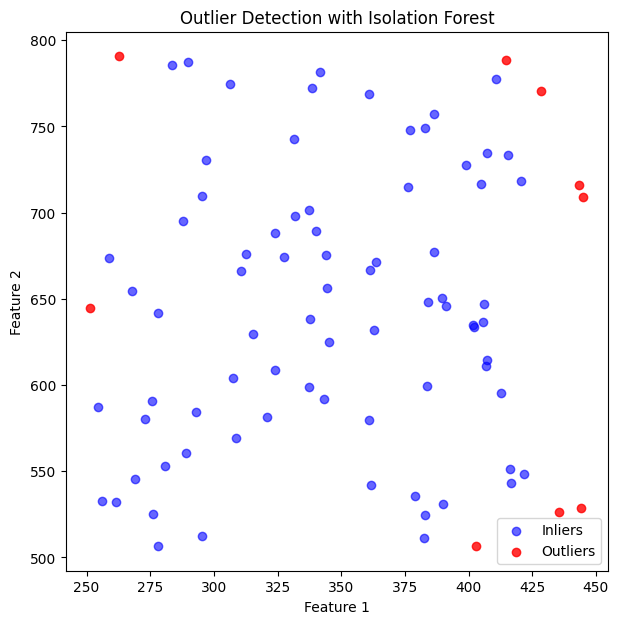

In [29]:
X = df.iloc[:, :2]
iso = IsolationForest(contamination=0.1, random_state=42)
yhat = iso.fit_predict(X)

mask = yhat != -1
X_inliers = X[mask]
X_outliers = X[~mask]

plt.figure(figsize=(7,7))
plt.scatter(X_inliers.iloc[:,0], X_inliers.iloc[:,1], c="blue", label="Inliers", alpha=0.6)
plt.scatter(X_outliers.iloc[:,0], X_outliers.iloc[:,1], c="red", label="Outliers", alpha=0.8)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Outlier Detection with Isolation Forest")
plt.legend()
plt.show()

In [50]:
df = df.copy()
X_features = df.drop(columns=["Compressive_strength", "CPC"])
outlier_pred = iso.fit_predict(X_features)

df_clean = df[outlier_pred == 1].reset_index(drop=True)
print("Shape original:", df.shape)
print("Shape after remove outlier:", df_clean.shape)

Shape original: (86, 8)
Shape after remove outlier: (77, 8)


In [51]:
df_clean.columns

Index(['Cement', 'M_sand', 'Fly_ash', 'W_B_ratio', 'Water_reducer', 'Gravel',
       'Compressive_strength', 'CPC'],
      dtype='object')

In [52]:
df_clean.describe()

,Cement,M_sand,Fly_ash,W_B_ratio,Water_reducer,Gravel,Compressive_strength,CPC
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,347.707243,646.508007,50.017299,0.440887,2.608424,1147.732658,194.455823,148.643949
std,52.393019,79.722996,30.304348,0.084544,1.516321,79.930627,17.044037,8.605439
min,254.542415,506.483624,1.393629,0.314776,0.027149,1010.817950,154.693854,130.119056
25%,307.665621,584.370135,22.965603,0.369771,1.266917,1090.402790,185.612195,141.684189
50%,344.219241,645.997499,50.632993,0.438840,2.862153,1152.505822,194.537030,149.481863
75%,391.033076,709.912140,78.476345,0.508439,3.913121,1209.436235,206.849032,154.611738
max,443.501946,790.752913,97.182643,0.584657,4.995524,1294.061435,228.975504,164.207475


In [53]:
X = df_clean.iloc[:, :6].values   # feature
y = df_clean.iloc[:, 6:].values   # label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [37]:
# model = MultiOutputRegressor(
#     XGBRegressor(
#         n_estimators=300,
#         learning_rate=0.05,
#         max_depth=3,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         reg_lambda=5,
#         reg_alpha=2,
#         random_state=42
#     )
# )

# model.fit(X_train, y_train)
# y_pred_train = model.predict(X_train)
# y_pred_test = model.predict(X_test)

In [251]:
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBRegressor(random_state=42)
multi_model = MultiOutputRegressor(xgb)

param_dist = {
    "estimator__n_estimators": [150, 200, 300, 400, 500],
    "estimator__learning_rate": [0.01, 0.03, 0.05],
    "estimator__max_depth": [2, 3],
    "estimator__subsample": [0.7, 0.8, 0.9],
    "estimator__colsample_bytree": [0.7, 0.8, 0.9],
    "estimator__reg_lambda": [5, 10],
    "estimator__reg_alpha": [3, 5, 7],
    "estimator__gamma": [2, 3],
    "estimator__min_child_weight": [3, 4]
}


kf = KFold(n_splits=10, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=multi_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=kf,
    scoring="r2",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [252]:
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV R²:", search.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best params: {'estimator__subsample': 0.8, 'estimator__reg_lambda': 5, 'estimator__reg_alpha': 3, 'estimator__n_estimators': 400, 'estimator__min_child_weight': 4, 'estimator__max_depth': 2, 'estimator__learning_rate': 0.05, 'estimator__gamma': 3, 'estimator__colsample_bytree': 0.9}
Best CV R²: 0.45355771831975644


In [117]:
search.best_estimator_

,estimator,"XGBRegressor(...ree=None, ...)"
,n_jobs,None
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None


In [254]:
def calc_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse
    
y_pred_train = search.predict(X_train)
y_pred_test = search.predict(X_test)

# CS
r2_cs_train, rmse_cs_train = calc_metrics(y_train[:,0], y_pred_train[:,0])
r2_cs_test,  rmse_cs_test  = calc_metrics(y_test[:,0],  y_pred_test[:,0])

# CPC
r2_cpc_train, rmse_cpc_train = calc_metrics(y_train[:,1], y_pred_train[:,1])
r2_cpc_test,  rmse_cpc_test  = calc_metrics(y_test[:,1],  y_pred_test[:,1])

print("Train:")
print(f"CS  - R²: {r2_cs_train:.3f}, RMSE: {rmse_cs_train:.3f}")
print(f"CPC - R²: {r2_cpc_train:.3f}, RMSE: {rmse_cpc_train:.3f}")

print("Test:")
print(f"CS  - R²: {r2_cs_test:.3f}, RMSE: {rmse_cs_test:.3f}")
print(f"CPC - R²: {r2_cpc_test:.3f}, RMSE: {rmse_cpc_test:.3f}")

Train:
CS  - R²: 0.985, RMSE: 1.880
CPC - R²: 0.960, RMSE: 1.675
Test:
CS  - R²: 0.877, RMSE: 7.756
CPC - R²: 0.865, RMSE: 3.194


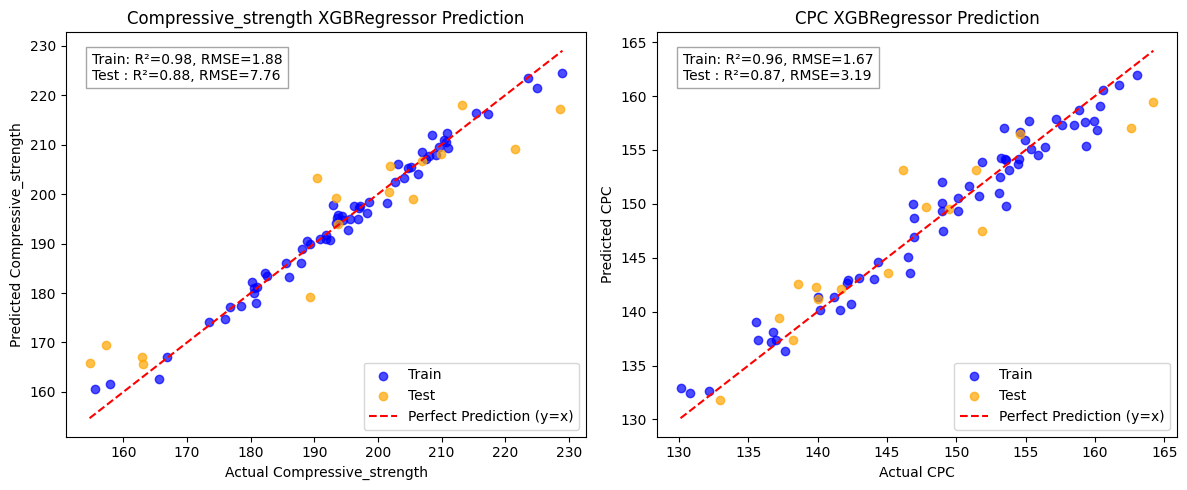

In [255]:
plt.figure(figsize=(12,5))

# Compressive Strength
plt.subplot(1,2,1)
plt.scatter(y_train[:,0], y_pred_train[:,0], alpha=0.7, color="blue", label="Train")
plt.scatter(y_test[:,0], y_pred_test[:,0], alpha=0.7, color="orange", label="Test")
plt.plot([min(y_train[:,0].min(), y_test[:,0].min()),
          max(y_train[:,0].max(), y_test[:,0].max())],
         [min(y_train[:,0].min(), y_test[:,0].min()),
          max(y_train[:,0].max(), y_test[:,0].max())],
         'r--', label="Perfect Prediction (y=x)")
plt.text(0.05, 0.95,
         f"Train: R²={r2_cs_train:.2f}, RMSE={rmse_cs_train:.2f}\n"
         f"Test : R²={r2_cs_test:.2f}, RMSE={rmse_cs_test:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xlabel("Actual Compressive_strength")
plt.ylabel("Predicted Compressive_strength")
plt.title("Compressive_strength XGBRegressor Prediction")
plt.legend()

# CPC
plt.subplot(1,2,2)
plt.scatter(y_train[:,1], y_pred_train[:,1], alpha=0.7, color="blue", label="Train")
plt.scatter(y_test[:,1], y_pred_test[:,1], alpha=0.7, color="orange", label="Test")
plt.plot([min(y_train[:,1].min(), y_test[:,1].min()),
          max(y_train[:,1].max(), y_test[:,1].max())],
         [min(y_train[:,1].min(), y_test[:,1].min()),
          max(y_train[:,1].max(), y_test[:,1].max())],
         'r--', label="Perfect Prediction (y=x)")
plt.text(0.05, 0.95,
         f"Train: R²={r2_cpc_train:.2f}, RMSE={rmse_cpc_train:.2f}\n"
         f"Test : R²={r2_cpc_test:.2f}, RMSE={rmse_cpc_test:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
plt.xlabel("Actual CPC")
plt.ylabel("Predicted CPC")
plt.title("CPC XGBRegressor Prediction")
plt.legend()

plt.tight_layout()
plt.show()

In [256]:
import pickle
with open("best_xgb_model.pkl", "wb") as f:
    pickle.dump(search.best_estimator_, f)

# with open("best_xgb_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)

In [104]:
with open("best_xgb_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [ ]:
# mean_squared_error(cs, xgb.predict(cm)), r2_score(cs, xgb.predict(cm)), mean_absolute_error(cs, xgb.predict(cm))